### Data Preparation

In [1]:
from io import open
import glob
import os

In [2]:
def findFiles(path):
    return glob.glob(path)

In [3]:
print(findFiles('../data/Names/names/*.txt'))

['../data/Names/names/French.txt', '../data/Names/names/Vietnamese.txt', '../data/Names/names/English.txt', '../data/Names/names/Greek.txt', '../data/Names/names/Dutch.txt', '../data/Names/names/German.txt', '../data/Names/names/Irish.txt', '../data/Names/names/Czech.txt', '../data/Names/names/Arabic.txt', '../data/Names/names/Russian.txt', '../data/Names/names/Portuguese.txt', '../data/Names/names/Chinese.txt', '../data/Names/names/Spanish.txt', '../data/Names/names/Korean.txt', '../data/Names/names/Scottish.txt', '../data/Names/names/Japanese.txt', '../data/Names/names/Italian.txt', '../data/Names/names/Polish.txt']


In [4]:
import unicodedata
import string

In [5]:
all_letters = string.ascii_letters + ".,;'"
n_letters = len(all_letters)

In [6]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s) 
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [7]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [8]:
category_lines = {}
all_categories = []

In [9]:
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [10]:
for filename in findFiles('../data/Names/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [11]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


### Turning Names into Tensors

In [12]:
import torch

In [13]:
def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [14]:
print(letterToTensor('J'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])


In [15]:
print(lineToTensor('Jones').size())

torch.Size([5, 1, 56])


### Creating the Network

In [16]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [17]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [18]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, hidden = rnn(input, hidden)

In [19]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9163, -2.8433, -2.8816, -2.8603, -2.8055, -2.9289, -2.9255, -2.9323,
         -2.8359, -2.9467, -2.8892, -2.9629, -2.8685, -2.8795, -2.9437, -2.7871,
         -2.8995, -2.9419]], grad_fn=<LogSoftmaxBackward0>)


### Training

#### Preparing for Training

In [20]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [21]:
print(categoryFromOutput(output))

('Japanese', 15)


In [22]:
import random

In [23]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [24]:
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Greek / line = Karkampasis
category = French / line = Vipond
category = Dutch / line = Horn
category = Irish / line = Delaney
category = Japanese / line = Shigeki
category = Vietnamese / line = Diep
category = Czech / line = Cernochova
category = Polish / line = Rutkowski
category = French / line = Mercier
category = Irish / line = Connolly


#### Training the Network

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.NLLLoss()

In [26]:
rnn = rnn.to(device)

In [27]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden().to(device)
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [28]:
import time 
import math

In [29]:
n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    category_tensor, line_tensor = category_tensor.to(device), line_tensor.to(device)
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (
            iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct
        ))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 17s) 1.6645 Poniros / Greek ✓
10000 10% (0m 35s) 2.6385 Mcintosh / Czech ✗ (Scottish)
15000 15% (0m 53s) 1.2865 Rui / Chinese ✓
20000 20% (1m 10s) 1.8485 Chaput / French ✓
25000 25% (1m 27s) 3.6713 Jez / Korean ✗ (Polish)
30000 30% (1m 45s) 2.5855 Vilchek / Czech ✗ (Russian)
35000 35% (2m 3s) 3.1200 D'cruze / French ✗ (Portuguese)
40000 40% (2m 20s) 1.3876 Garcia / Italian ✗ (Portuguese)
45000 45% (2m 37s) 0.7979 Xie / Chinese ✓
50000 50% (2m 55s) 1.0418 Mersinias / Greek ✓
55000 55% (3m 12s) 4.3076 Cerney / Irish ✗ (Czech)
60000 60% (3m 30s) 0.6957 Odaka / Japanese ✓
65000 65% (3m 47s) 1.6419 Freudenberger / French ✗ (German)
70000 70% (4m 5s) 1.1950 Brand / Scottish ✗ (German)
75000 75% (4m 22s) 0.0814 Roncalli / Italian ✓
80000 80% (4m 39s) 1.4564 Cabello / Italian ✗ (Spanish)
85000 85% (4m 57s) 0.6261 Salvage / French ✓
90000 90% (5m 15s) 0.9838 Makuda / Japanese ✓
95000 95% (5m 32s) 0.3716 Salamanca / Spanish ✓
100000 100% (5m 49s) 2.5668 Kubin / Russian ✗ (Czech)


#### Plotting the Results

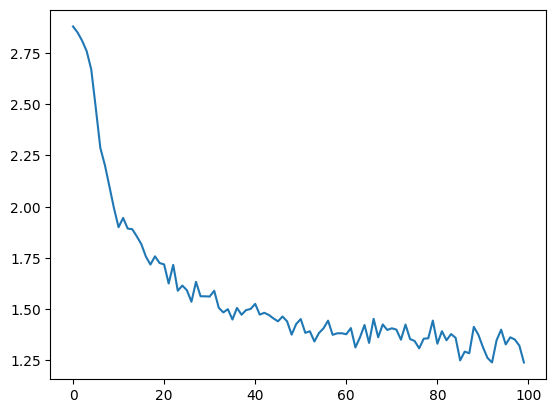

In [30]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

### Evaluating the Results

/tmp/ipykernel_1509742/4086733437.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_1509742/4086733437.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


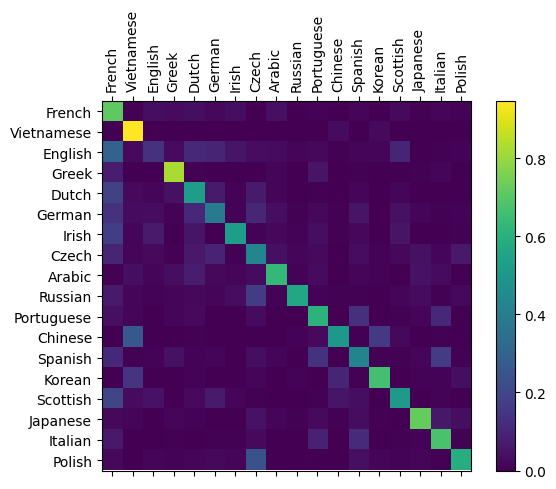

In [31]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden().to(device)

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    category_tensor, line_tensor = category_tensor.to(device), line_tensor.to(device)
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [32]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line).to(device))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.26) Czech
(-2.13) Russian
(-2.85) English

> Jackson
(-0.56) Scottish
(-2.06) English
(-2.21) French

> Satoshi
(-1.00) Italian
(-1.49) Polish
(-1.89) Japanese
